# Libraries

In [1]:
# Use with base (Python 3.13.2)
import os
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import pingouin as pg
from pingouin import ancova
from matplotlib.patches import Patch
#import statannotations as sa
from statannotations.Annotator import Annotator
import xlsxwriter
import lxml

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

from datetime import datetime
from __future__ import absolute_import, print_function

# Directories


In [2]:
ROOT = Path().resolve().parent      # one level up from current dir
hypercapnia_df_t2 = pd.read_csv(ROOT / "data/Hypercapnia/T2_results.csv")
hypercapnia_df_fmri = pd.read_csv(ROOT / "data/Hypercapnia/fMRI_results.csv")

# Prep the dataframes

In [3]:
T2 = hypercapnia_df_t2
t2_fmri_corr = hypercapnia_df_fmri    

# Define a function to split the table in first session and both sessions
def extract_last_digit_and_filter(df, what):
    # Extract the last digit of the 'subID' column
    df['state'] = df['subject'].astype(str).str[-2]
    
    # Convert the last digit to integer type
    df['state'] = df['state'].apply(lambda x: "normocapnia" if x.startswith('N') else "hypercapnia")
    
    df['subID'] = df['subject'].astype(str).str[:-3]
    
    # Convert the last digit to integer type
    #df['subID'] = df['subID']
    
    if what == 'normo':
        #Create a new DataFrame with rows where 'session' equals 1
        original_name_normo = df[df['state'] == 'normocapnia'].copy()
    
        return original_name_normo
    else:
        #Create a new DataFrame with rows where 'session' equals 1
        original_name_hyper = df[df['state'] == 'hypercapnia'].copy()
    
        return original_name_hyper

# Extracting everything of interest out of the fMRI Dataframe
#T2 = T2[['subject', 'subID','state','rightLateralVentricle','bothVentricles','x3rdVentricle','x4thVentricle','csf']]
t2_normo = extract_last_digit_and_filter(T2,'normo')

# Add in Variable for whole cortex as a sum
t2_normo['wholeCortex'] = t2_normo['leftCerebralCortex'] + t2_normo['rightCerebralCortex']
t2_normo['wholeWM'] = t2_normo['leftCerebralWhiteMatter'] + t2_normo['rightCerebralWhiteMatter']
t2_normo['wholeParenchyma'] = t2_normo['wholeCortex'] + t2_normo['wholeWM']

# Drop out subjects
t2_normo = t2_normo[t2_normo['subID']!='sub-001'] # Has no fMRI
t2_normo = t2_normo[t2_normo['subID']!='sub-008'] # Head motion in fMRI
t2_normo = t2_normo[t2_normo['subID']!='sub-013'] # Head motion in fMRI
t2_normo = t2_normo[t2_normo['subID']!='sub-005'] # Wrong acquisition order


t2_hyper = extract_last_digit_and_filter(T2,'hyper')

# Add in Variable for whole cortex as a sum
t2_hyper['wholeCortex'] = t2_hyper['leftCerebralCortex'] + t2_hyper['rightCerebralCortex']
t2_hyper['wholeWM'] = t2_hyper['leftCerebralWhiteMatter'] + t2_hyper['rightCerebralWhiteMatter']
t2_hyper['wholeParenchyma'] = t2_hyper['wholeCortex'] + t2_hyper['wholeWM']

# Drop out subjects
t2_hyper = t2_hyper[t2_hyper['subID']!='sub-001'] # Has no fMRI
t2_hyper = t2_hyper[t2_hyper['subID']!='sub-008'] # Excessive Head Motion in fMRI
t2_hyper = t2_hyper[t2_hyper['subID']!='sub-013'] # Wrong Scanning acquisition
t2_hyper = t2_hyper[t2_hyper['subID']!='sub-005'] # Excessive Head Motion in fMRI

t2_both = pd.concat([t2_normo, t2_hyper])
    
# Drop out subjects we do not want
t2_fmri_corr = t2_fmri_corr[t2_fmri_corr['sub_id']!='sub-001'] # Has no fMRI
t2_fmri_corr = t2_fmri_corr[t2_fmri_corr['sub_id']!='sub-008'] # Excessive Head Motion in fMRI
t2_fmri_corr = t2_fmri_corr[t2_fmri_corr['sub_id']!='sub-013'] # Wrong Scanning acquisition
t2_fmri_corr = t2_fmri_corr[t2_fmri_corr['sub_id']!='sub-005'] # Excessive Head Motion in fMRI


pd.set_option('display.max_rows', None)



# Prep the dataframes - Normalization

In [6]:
# Normalize the dataframes
#del t2_hyper_norm
#del t2_normo_norm
#del t2_both_norm

# Global flag to check if normalization has been done
if 't2_normo_norm' not in globals():
    # Normalize df1 by dividing it by df2 (element-wise division)
    t2_normo_norm = t2_normo.select_dtypes(include='number') / t2_normo.select_dtypes(include='number')
    print("Normalization completed!")
else:
    print("Normalization already done!")

#print(t2_normo_norm)

# Global flag to check if normalization has been done
if 't2_hyper_norm' not in globals():
    # Normalize df1 by dividing it by df2 (element-wise division)
    # Align indexes first if needed or ignore index (element-wise division without aligning indices)
    t2_hyper_norm = t2_hyper.select_dtypes(include='number').reset_index(drop=True) / \
                    t2_normo.select_dtypes(include='number').reset_index(drop=True)
    print("Normalization completed!")
else:
    print("Normalization already done!")


# Calculate absolute difference in ventricle_volume
if 't2_both_norm' not in globals():
    t2_both_norm = pd.concat([t2_normo_norm, t2_hyper_norm])
    t2_both_norm[['subID', 'state', 'subject']] = t2_both[['subID', 'state', 'subject']].values


Normalization already done!
Normalization already done!


# Edit the RC file

In [7]:
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica Neue"],
    "svg.fonttype": "none"
})

# Panel 1B


T-statistic: -7.111720479469764
P-value: 1.9632225322481774e-05
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

normocapnia vs. hypercapnia: ****
T-statistic: 4.229420290236815
P-value: 0.0014137952127339264
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

normocapnia vs. hypercapnia: **


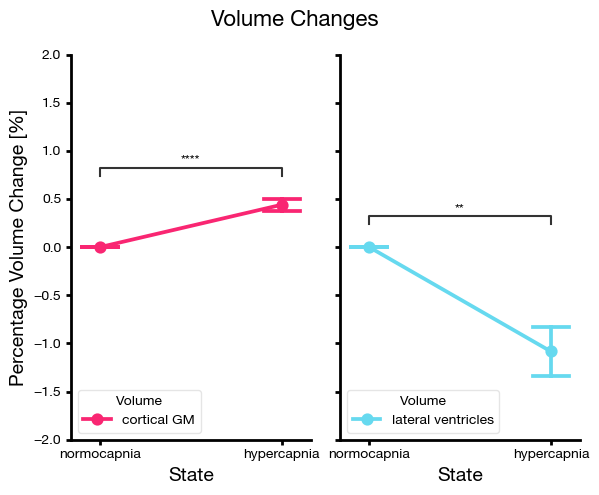

In [8]:
#del t2_structural_catplot
t2_structural_catplot = pd.DataFrame()
t2_structural_catplot['percentage_cortex'] = (t2_both_norm['wholeCortex'] - 1) * 100
t2_structural_catplot['label_cortex'] = 'cortical GM'
t2_structural_catplot['percentage_ventricles'] = (t2_both_norm['bothVentricles'] - 1) * 100
t2_structural_catplot['label_ventricles'] = 'lateral ventricles'
t2_structural_catplot['State'] = t2_both_norm['state']
t2_structural_catplot['subID'] = t2_both_norm['subID']


 # Palette for GM
monokai_pro_palette_gm = [
    (249, 38, 114),   # Red

]
# Convert RGB values to a format Seaborn understands (scaled between 0 and 1)
monokai_pro_palette_gm = [(r / 255, g / 255, b / 255) for r, g, b in monokai_pro_palette_gm]
 
 # Palette for ventricles
monokai_pro_palette_ventricle = [
    (102, 217, 239),  # Blue

]
# Convert RGB values to a format Seaborn understands (scaled between 0 and 1)
monokai_pro_palette_ventricle = [(r / 255, g / 255, b / 255) for r, g, b in monokai_pro_palette_ventricle]
 
 
fig, axes = plt.subplots(1, 2, figsize=(6, 5), sharey=True)

# Add a central title for the entire figure
fig.suptitle("Volume Changes", fontsize=16, weight='bold')

# Cortex volume change
sns.pointplot(
    ax=axes[0],
    data=t2_structural_catplot,
    x="State",
    hue="label_cortex",
    y="percentage_cortex",
    palette=monokai_pro_palette_gm,
    capsize=0.2,
    errorbar="se",
    #label="Cortical GM"
)
axes[0].set_ylabel('Percentage Volume Change [%]', fontsize=14)
axes[0].set_xlabel('State', fontsize=14)
axes[0].set_ylim(-2, 2) 
axes[0].legend(loc="lower left", title="Volume",framealpha=0.5)
plt.tight_layout()
sns.despine()
# Annotate the Cortex plot
cortex_pairs = [("normocapnia", "hypercapnia")]
annotator = Annotator(axes[0], cortex_pairs, data=t2_structural_catplot, x="State", y="percentage_cortex")

# Perform statistical testing between groups
# Extract data for group1 where State == "Normocapnia"
group1 = t2_structural_catplot.loc[t2_structural_catplot['State'] == "normocapnia", 'percentage_cortex']

# Extract data for group2 where State == "Hypercapnia"
group2 = t2_structural_catplot.loc[t2_structural_catplot['State'] == "hypercapnia", 'percentage_cortex']

# Perform paired t-test
t_stat, p_value = stats.ttest_rel(group1, group2)

# Display the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

rounded_p_value = round(p_value, 2)
rounded_p_value_str = f"$\\it{{p}} = {rounded_p_value}$"  # Using LaTeX for 'p'

# Initialize an empty list to store formatted p-values
formatted_pvalues_list = []

# Format p-value for annotation
if p_value <= 1e-4:
    formatted_pvalue = '****'
elif p_value <= 1e-3:
    formatted_pvalue = '***'
elif p_value <= 1e-2:
    formatted_pvalue = '**'
elif p_value <= 5e-2:
    formatted_pvalue = '*'
else:
    formatted_pvalue = 'ns'

# Set custom annotations for the pairs
pairs = [('normocapnia', 'hypercapnia')]  # Ensure correct pair naming
formatted_pvalues_list.append(formatted_pvalue)

annotator.set_custom_annotations([formatted_pvalue])
annotator.annotate()

# Ventricles volume change
sns.pointplot(
    ax=axes[1],
    data=t2_structural_catplot,
    x="State",
    hue="label_ventricles",
    y="percentage_ventricles",
    palette=monokai_pro_palette_ventricle,
    capsize=0.2,
    errorbar="se",
    #label="Lateral Ventricles"
)
axes[1].set_xlabel('State', fontsize=14)
axes[1].set_ylabel("")
axes[1].legend(loc="lower left", title="Volume",framealpha=0.5)
plt.tight_layout()

# Annotate the Ventricles plot
ventricles_pairs = [("normocapnia", "hypercapnia")]
annotator = Annotator(axes[1], ventricles_pairs, data=t2_structural_catplot, x="State", y="percentage_ventricles")
# Perform statistical testing between groups
# Extract data for group1 where State == "Normocapnia"
group1 = t2_structural_catplot.loc[t2_structural_catplot['State'] == "normocapnia", 'percentage_ventricles']

# Extract data for group2 where State == "Hypercapnia"
group2 = t2_structural_catplot.loc[t2_structural_catplot['State'] == "hypercapnia", 'percentage_ventricles']

# Perform paired t-test
t_stat, p_value = stats.ttest_rel(group1, group2)

# Display the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

rounded_p_value = round(p_value, 2)
rounded_p_value_str = f"$\\it{{p}} = {rounded_p_value}$"  # Using LaTeX for 'p'

# Initialize an empty list to store formatted p-values
formatted_pvalues_list = []

# Format p-value for annotation
if p_value <= 1e-4:
    formatted_pvalue = '****'
elif p_value <= 1e-3:
    formatted_pvalue = '***'
elif p_value <= 1e-2:
    formatted_pvalue = '**'
elif p_value <= 5e-2:
    formatted_pvalue = '*'
else:
    formatted_pvalue = 'ns'

# Set custom annotations for the pairs
pairs = [('normocapnia', 'hypercapnia')]  # Ensure correct pair naming
formatted_pvalues_list.append(formatted_pvalue)

annotator.set_custom_annotations([formatted_pvalue])
annotator.annotate()

# Set all axes and tick linewidths
for ax in axes:
    ax.tick_params(axis='both', width=2)
    for spine in ax.spines.values():
        spine.set_linewidth(2)

plt.show()
 
 
# Save the figure -------
#image_path = os.path.join(outDir, f'GM_Ventricle_Pointplot.png')
#fig.savefig(image_path,dpi=300, bbox_inches='tight')
#---
#image_path_svg = os.path.join(outDir, f'GM_Ventricle_Pointplot.svg')
#fig.savefig(image_path_svg)

# Panel 1G

      subject  timepoint     value   time
0           0          1  1.128631   24.6
1           1          1  1.330375   24.6
2           2          1  1.438624   24.6
3           3          1  0.426761   24.6
4           4          1  1.576629   24.6
5           5          1  1.227374   24.6
6           6          1  0.225289   24.6
7           7          1 -0.219494   24.6
8           8          1 -1.276645   24.6
9           9          1  0.371479   24.6
10         10          1  0.148950   24.6
11         11          1  0.989803   24.6
12          0          2  1.567879   28.7
13          1          2  0.661014   28.7
14          2          2  3.290240   28.7
15          3          2  0.375823   28.7
16          4          2  1.196872   28.7
17          5          2  1.359579   28.7
18          6          2  1.005439   28.7
19          7          2  0.534609   28.7
20          8          2 -1.391741   28.7
21          9          2  0.095898   28.7
22         10          2  0.654434

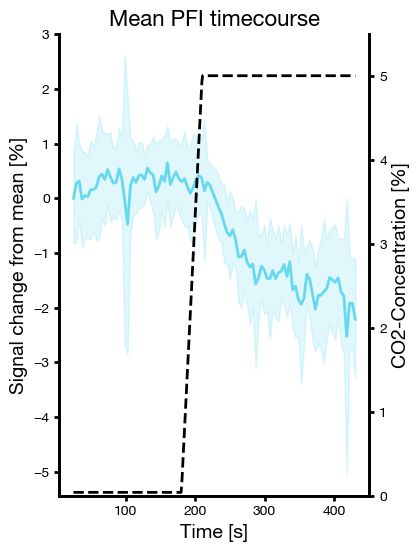

In [9]:
# Extract the timecourse data from the fMRI DataFrame
timecourse_columns = [col for col in t2_fmri_corr.columns if col.startswith("ventricle_border_tc_normalized_")]

# Extract the relevant data and convert it into a "long" format for Seaborn
timecourse_data = t2_fmri_corr[timecourse_columns].copy()
timecourse_data['subject'] = range(len(timecourse_data))
#timecourse_data['time'] = timecourse_data['timepoint'] * 4.1 # Add a subject identifier
#timecourse_data['value'] = 1-timecourse_data['value']

# Melt the DataFrame to long format
long_df = timecourse_data.melt(
    id_vars='subject',
    var_name='timepoint',
    value_name='value'
)

# Extract timepoint numbers for easier plotting
long_df['timepoint'] = long_df['timepoint'].str.extract(r'(\d+)').astype(int)
long_df['value'] = (long_df['value']-1) * 100
long_df['time'] = ((long_df['timepoint'].astype(int)) + 5) * 4.1
long_df = long_df.iloc[:1199, :] # Cutting down after row 1199, because then the Downramp happens again
print(long_df)

# Compute the first mean value (baseline shift)
first_value = long_df.groupby("time")["value"].mean().iloc[0]

# Shift all values so the first point is at zero
long_df["value"] -= first_value

time = np.arange(long_df['time'].min(), long_df['time'].max() + 1)
co2_concentration = np.piecewise(time, 
                                 [time < 180, (time >= 180) & (time <= 210), time > 210], 
                                 [0.04, lambda t: 0.04 + (5 - 0.04) * (t - 180) / 30, 5])
co2_df = pd.DataFrame({'timepoints': time, 'co2': co2_concentration})

# Plot using Seaborn
fig,ax1 = plt.subplots(figsize=(4, 6))
sns.lineplot(
    data=long_df,
    x='time',
    y='value',
    errorbar='sd',  # Shaded region shows standard deviation
    estimator='mean',  # Mean line
    linewidth=2,
    color=(102 / 255, 217 / 255, 239 / 255),
    ax = ax1
)

ax2 = ax1.twinx()  # Create a second y-axis
sns.lineplot(x="timepoints", y='co2', data=co2_df, ax=ax2, color='black', linestyle='dashed', linewidth=2)
ax2.set_ylabel("CO2-Concentration [%]", fontsize=14)
ax2.set_ylim(0, 5.5)
sns.despine(right=False, left=False)

plt.title('Mean PFI timecourse', fontsize=16, weight='bold')
ax1.set_xlabel('Time [s]', fontsize=14)
ax1.set_ylabel('Signal change from mean [%]', fontsize=14)
ax1.tick_params(axis='x', which='both', direction='out', width=2)  # Adjust the width as needed
ax1.tick_params(axis='y', which='both', direction='out', width=2)  # Adjust the width as needed
ax2.tick_params(axis='x', which='both', direction='out', width=2)  # Adjust the width as needed
ax2.tick_params(axis='y', which='both', direction='out', width=2)  # Adjust the width as needed
for spine in ax1.spines.values():
    spine.set_linewidth(2)
for spine in ax2.spines.values():
    spine.set_linewidth(2)
    
#plt.xlim(0,410)
#sns.despine()
plt.show()

# Save the figure -------
#image_path = os.path.join(outDir, f'Mean PFI timecourses.png')
#fig.savefig(image_path,dpi=600, bbox_inches='tight')
#---
#image_path_svg = os.path.join(outDir, f'Mean PFI timecourses.svg')
#fig.savefig(image_path_svg)

# Panel 1H

      subID  timecourse_normo_25  timecourse_normo_26  timecourse_normo_27  \
0   sub-002             1.748447             0.963351             1.099481   
1   sub-003             0.772846             0.376313             1.169074   
2   sub-004             0.365925             0.878181             0.608598   
3   sub-006             0.731795             0.328825             0.757938   
4   sub-007             1.350861             1.390754             1.831204   
5   sub-009             0.540100             0.537064             1.512060   
6   sub-010             0.663827             0.655066             0.925079   
7   sub-011             1.468288             0.897159             0.907044   
8   sub-012             1.234798             1.182937             1.234577   
9   sub-014             0.045089             1.667568             0.691845   
10  sub-015             1.885439             1.449316             1.302613   
11  sub-016             1.655521             1.175569           

/var/folders/ml/8kb9cd2x2yz10lfbvzrvfxy40000gn/T/ipykernel_5773/1504280632.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x="state_name",y='median_pfi_timecourse',data=pfi_timecourses_plot, palette=monokai_pro_palette_pfi, saturation=0.9, linewidth=2, inner="box", fill=False)
/var/folders/ml/8kb9cd2x2yz10lfbvzrvfxy40000gn/T/ipykernel_5773/1504280632.py:55: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  ax = sns.violinplot(x="state_name",y='median_pfi_timecourse',data=pfi_timecourses_plot, palette=monokai_pro_palette_pfi, saturation=0.9, linewidth=2, inner="box", fill=False)


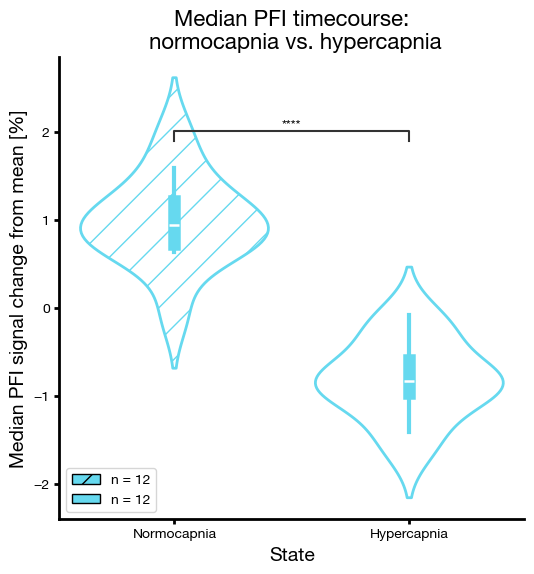

In [10]:
monokai_pro_palette_pfi = [
    #(204, 237, 242),   # Light intensity blue
    #(178, 229, 242),  # Medium intensity blue
    (102/255, 217/255, 239/255),  # Blue

]


# Create a list of the column names you're interested in
columns_of_interest_normo = [f'ventricle_border_tc_normalized_{i}' for i in range(25, 45)]
columns_of_interest_hyper = [f'ventricle_border_tc_normalized_{i}' for i in range(65, 85)]

# Create empty array
new_data = []

# Group by `sub_id` to process rows per subject
for sub_id, group in t2_fmri_corr.groupby('sub_id'):
    
    # Collect the first (or unique) value from each column of interest
    timecourse_values_normo = (group[columns_of_interest_normo].iloc[0].values * 100) - 100  # Get Percent Signal Change just like in the Plot of the timecourses
    timecourse_values_hyper = (group[columns_of_interest_hyper].iloc[0].values * 100) - 100 
    
    # Calculate the median
    median_value_normo = np.median(timecourse_values_normo)
    median_value_hyper = np.median(timecourse_values_hyper)
    
    # Append to new data
    new_row = {'subID': sub_id}
    new_row.update({f'timecourse_normo_{i}': timecourse_values_normo[i-25] for i in range(25, 45)})
    new_row['median_timecourse_normo'] = median_value_normo
    new_row.update({f'timecourse_hyper_{i}': timecourse_values_hyper[i-65] for i in range(65, 85)})
    new_row['median_timecourse_hyper'] = median_value_hyper
    new_data.append(new_row)

# Convert the list of dictionaries to a new dataframe
pfi_timecourses = pd.DataFrame(new_data)

# Display the resulting dataframe
print(pfi_timecourses)


# Now create the plot for the median pfi
pfi_timecourses_plot = pd.DataFrame()

pfi_timecourses_plot['median_pfi_timecourse'] = pd.concat([pfi_timecourses['median_timecourse_normo'],pfi_timecourses['median_timecourse_hyper']], axis=0)
pfi_timecourses_plot['subID'] = pd.concat([pfi_timecourses['subID'], pfi_timecourses['subID']], axis=0)

# Set values in the second column
pfi_timecourses_plot_categorical = [0] * len(pfi_timecourses) + [1] * len(pfi_timecourses)
pfi_timecourses_plot['state_categorical'] = pfi_timecourses_plot_categorical
pfi_timecourses_plot['state_name'] = pfi_timecourses_plot['state_categorical'].apply(lambda x: "Normocapnia" if x == 0 else "Hypercapnia")


fig = plt.figure(figsize=(6, 6))
ax = sns.violinplot(x="state_name",y='median_pfi_timecourse',data=pfi_timecourses_plot, palette=monokai_pro_palette_pfi, saturation=0.9, linewidth=2, inner="box", fill=False)

ax.tick_params(axis='x', which='both', direction='out', width=2)  # Adjust the width as needed
ax.tick_params(axis='y', which='both', direction='out', width=2)  # Adjust the width as needed
sns.despine()  # Adjust spines


for i, violin in enumerate(ax.collections):
    if i == 0:  # Apply pattern to the first violin
        violin.set_hatch('/')  # Apply hatch pattern
        #violin.set_facecolor('none')  # Make the face color transparent
        #violin.set_edgecolor('red')   # Set the edge color to red

pfi_timecourses_plot['subID'] = pfi_timecourses_plot['subID'].astype(str)



# Do a paired ttest for non normal data
# Perform statistical testing between groups
group1 = pfi_timecourses['median_timecourse_normo']
group2 = pfi_timecourses['median_timecourse_hyper']

# Perform paired t-test
t_stat, p_value = stats.ttest_rel(group1, group2)
print(t_stat)
print(p_value)


# Get the current axis
ax = plt.gca()

# Add statistical annotations
plotting_parameters = {
            'data':    pfi_timecourses_plot,
            'x':       'state_name',
            'y':       'median_pfi_timecourse',
            #'hue':     'subID'
        }

         
         
pairs = [('Normocapnia', 'Hypercapnia')]       

# Extract p-value
pvalue = p_value
print(pvalue)

# Initialize an empty list to store formatted p-values
formatted_pvalues_list = []

# Format p-value
if pvalue <= 1e-4:
    formatted_pvalue = '****'
elif pvalue <= 1e-3:
    formatted_pvalue = '***'
elif pvalue <= 1e-2:
    formatted_pvalue = '**'
elif pvalue <= 5e-2:
    formatted_pvalue = '*'
else:
    formatted_pvalue = 'ns'
    
# Convert single p-value to a list
formatted_pvalues_list = [formatted_pvalue]


# Set custom annotations
annotator = Annotator(ax, pairs, **plotting_parameters)
annotator.set_custom_annotations(formatted_pvalues_list)
annotator.annotate()

for spine in ax.spines.values():
    spine.set_linewidth(2)

# Coupling Gruppe - Annot
plt.title(f'Median PFI timecourse:\n normocapnia vs. hypercapnia',fontsize = 16, weight = 'bold')
plt.xlabel('State', fontsize = 14)
plt.ylabel('Median PFI signal change from mean [%]', fontsize = 14)
#annotator = Annotator(ax, pairs, **plotting_parameters)
#annotator.set_custom_annotations(formatted_pvalue)
#annotator.set_pvalues_and_annotate(pvalues)


colors = [artist.get_facecolor() for artist in ax.collections]


# new way:
legend_patches = [
    Patch(facecolor=(102/255, 217/255, 239/255), edgecolor='black', hatch='/', label=f'n = {len(pfi_timecourses)}'),
    Patch(facecolor=(102/255, 217/255, 239/255), edgecolor='black', label=f'n = {len(pfi_timecourses)}')
]

# Add legend with custom patches
ax.legend(handles=legend_patches, loc='lower left')


# Save the figure -------
#image_path = os.path.join(outDir, f'Median PFI timecourse difference.png')
#fig.savefig(image_path,dpi=600)
#---
#image_path_svg = os.path.join(outDir, 'Median PFI timecourse difference.svg')
#fig.savefig(image_path_svg)

# Panel 1I

    session_id  PFI_median_subtraction_nc_hc_normalized  \
0            1                                 0.028655   
1            1                                 0.015050   
2            1                                 0.023068   
3            1                                 0.016341   
4            1                                 0.024252   
5            1                                 0.017881   
6            1                                 0.018521   
7            1                                 0.026773   
8            1                                 0.010447   
9            1                                 0.001144   
10           1                                 0.011159   
11           1                                 0.023786   

    ventricle_border_tc_normalized_1  ventricle_border_tc_normalized_2  \
0                           1.011286                          1.015679   
1                           1.013304                          1.006610   
2         

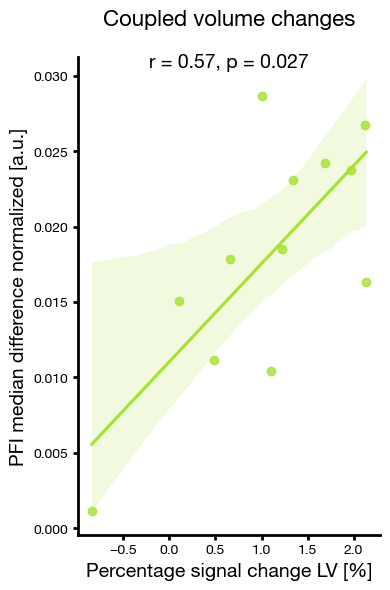

In [11]:
# Merge t2_hyper_norm with FMRI amplitude

fmri_one = t2_fmri_corr[t2_fmri_corr['session_id'] == 1]
fmri_one['subID'] = fmri_one['sub_id']
fmri_one = fmri_one.drop(columns = ['sub_id'])

#fmri_one
t2_hyper_norm['subID'] = t2_hyper['subID'].reset_index(drop=True)

#-----------
t2_fmri_corr = pd.merge(fmri_one,t2_hyper_norm,on='subID',how='inner') 


t2_fmri_corr['bothVentricles'] = ((t2_fmri_corr['bothVentricles']-1)*(-100))
t2_fmri_corr['PFI_median_subtraction_nc_hc_normalized'] = t2_fmri_corr['PFI_median_subtraction_nc_hc_normalized']
# Correlate both ventricles absolute volume difference with PFI amplitude in batch

#t2_fmri_corr = t2_fmri_corr.drop(9, axis=0)
print(t2_fmri_corr)

fig = plt.figure(figsize=(4, 6))
ax = sns.regplot(data=t2_fmri_corr, y='PFI_median_subtraction_nc_hc_normalized', x='bothVentricles', color=(166/255, 226/255, 46/255))
plt.title('Coupled volume changes', weight='bold', fontsize=16, y=1.05)
plt.ylabel('PFI median difference normalized [a.u.]', fontsize=14)
plt.xlabel('Percentage signal change LV [%]', fontsize=14)

ax.tick_params(axis='x', which='both', direction='out', width=2)  # Adjust the width as needed
ax.tick_params(axis='y', which='both', direction='out', width=2)  # Adjust the width as needed
for spine in ax.spines.values():
    spine.set_linewidth(2)
sns.despine()
# Add the correlation values
# Left grey matter and lateral ventricle
column1 = t2_fmri_corr['bothVentricles']  # Column from first dataframe
column2 = t2_fmri_corr['PFI_median_subtraction_nc_hc_normalized']  # Column from second dataframe

# Option 1: Using scipy.stats.spearmanr
spearman_corr, spearman_p_value = stats.spearmanr(column1, column2)
spearman_p_value = spearman_p_value/2 # Test only in one direction

print(f"Spearman Correlation Coefficient: {spearman_corr}")
print(f"P-value: {spearman_p_value}")

p_value = spearman_p_value
if p_value < 0.001:
    p_str = 'p < 0.001'
else:
    p_str = f'p = {p_value:.3f}'

plt.text(0.5, 0.98, f"r = {spearman_corr:.2f}, {p_str}", fontsize=14, ha='center', transform=plt.gca().transAxes)
plt.tight_layout()

# Save the figure -------
#image_path = os.path.join(outDir, f'Association of bothVentricles and PFI median normalized.png')
#plt.savefig(image_path, dpi=600)
#---
#image_path_svg = os.path.join(outDir, 'Association of bothVentricles and PFI median normalized.svg')
#plt.savefig(image_path_svg)

#t2_fmri_corr

# Mock CO2-Curve

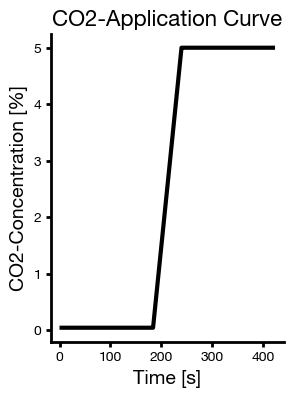

In [12]:
# Parameters
frames_constant_start = 45
frames_ramp = 15
frames_constant_end = 45
start_value = 0.04  # Start percentage
end_value = 5.0     # End percentage

# Generate data
constant_start = [start_value] * frames_constant_start
ramp = np.linspace(start_value, end_value, frames_ramp)
constant_end = [end_value] * frames_constant_end

# Combine all frames into one series
data = np.concatenate([constant_start, ramp, constant_end])

# Create a DataFrame for better visualization or saving
frame_numbers = np.arange(1, len(data) + 1)
mock_data = pd.DataFrame({"Frame": frame_numbers * 4, "Value": data})


# Plot the data
fig = plt.figure(figsize=(3, 4))
ax = sns.lineplot(data=mock_data, x="Frame", y="Value", color = 'black', linewidth = 3)


    

plt.title("CO2-Application Curve",fontsize = 16, weight = 'bold')
plt.xlabel("Time [s]",fontsize = 14)
plt.ylabel("CO2-Concentration [%]",fontsize = 14)
ax.tick_params(axis='x', which='both', direction='out', width=2)  # Adjust the width as needed
ax.tick_params(axis='y', which='both', direction='out', width=2)  # Adjust the width as needed
for spine in ax.spines.values():
    spine.set_linewidth(2)
sns.despine()  # Adjust spines
plt.show()

# Save the figure -------
#image_path = os.path.join(outDir, f'CO2_Application_Curve.png')
#fig.savefig(image_path,dpi=600)
#---
#image_path_svg = os.path.join(outDir, 'CO2_Application_Curve.svg')
#fig.savefig(image_path_svg)



